<a href="https://colab.research.google.com/github/Vreddy0305/Machine-Learning-ML-/blob/main/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== B1: kNN Streamflow Classification ===
Train Confusion Matrix:
 [[2825  354]
 [   0 3152]]
Train -> Precision: 0.899, Recall: 1.000, F1: 0.947
Test Confusion Matrix:
 [[1195  168]
 [   0 1351]]
Test -> Precision: 0.889, Recall: 1.000, F1: 0.941

=== B2: Linear Regression on Flow ===
MSE: 1.017
RMSE: 1.009
MAPE: 40.27%
R²: 0.971


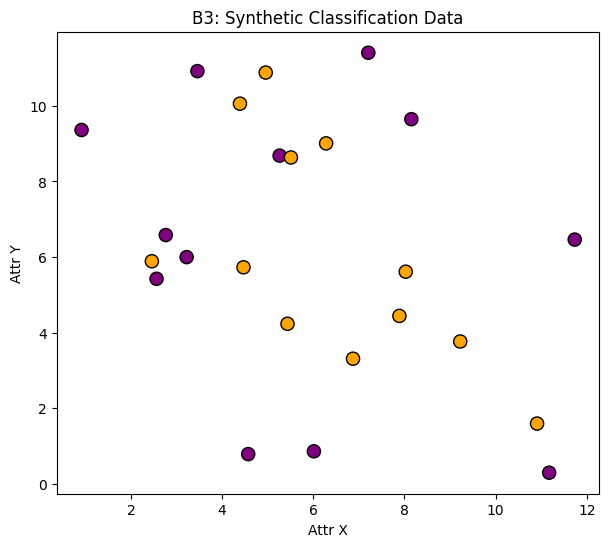

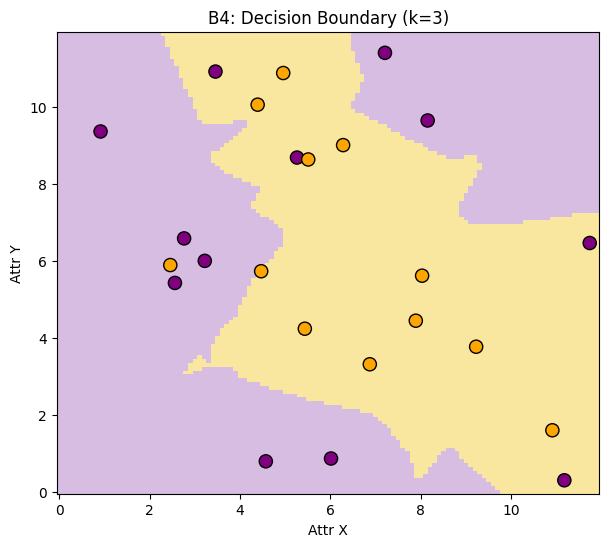

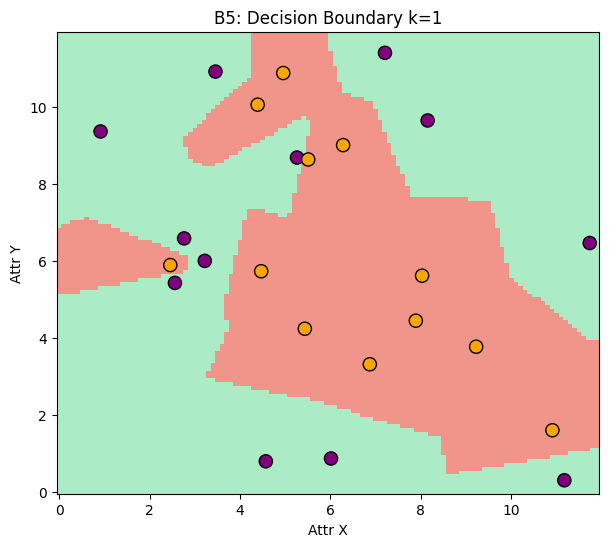

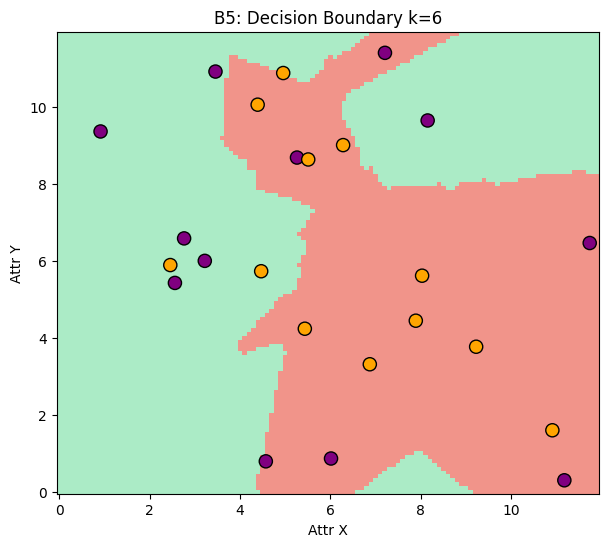

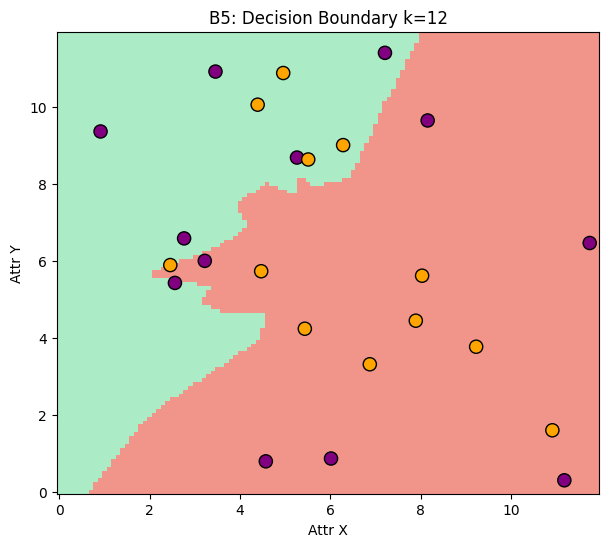

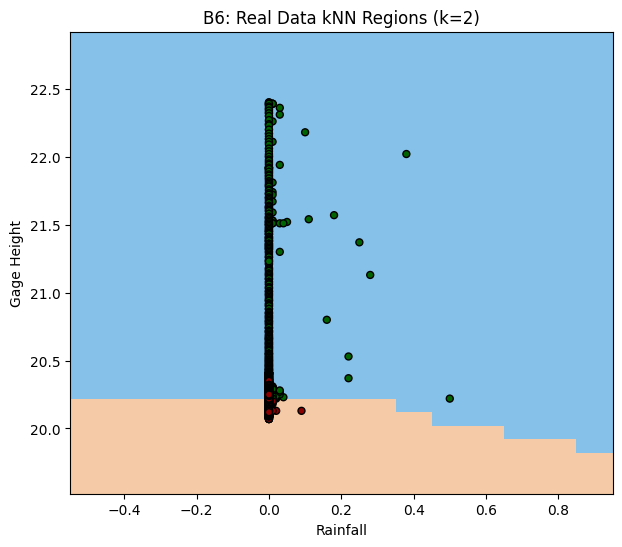

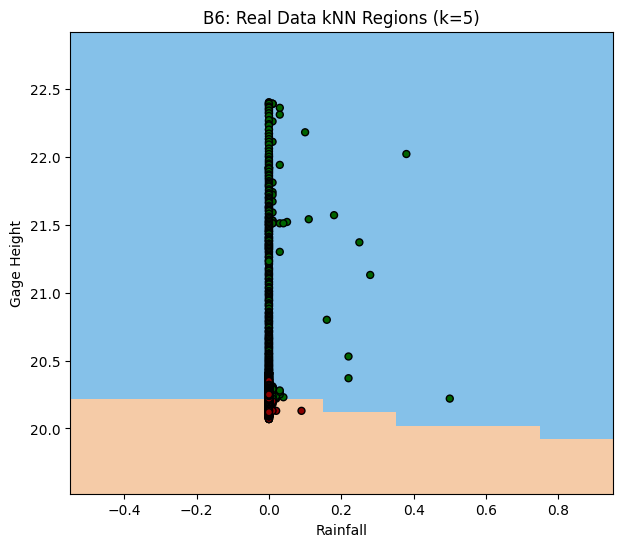

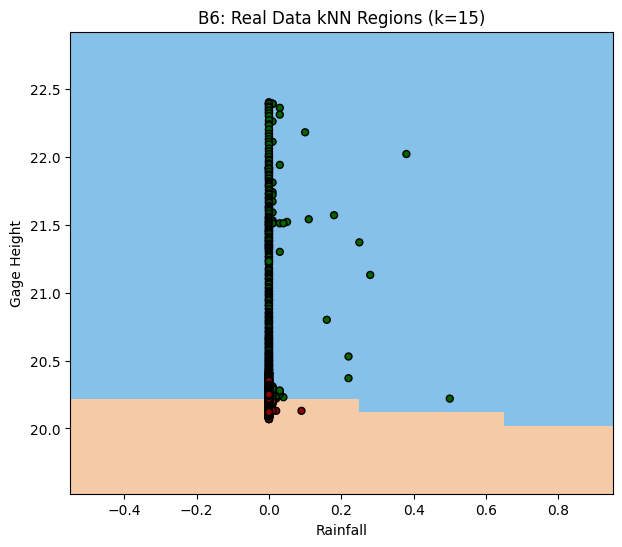

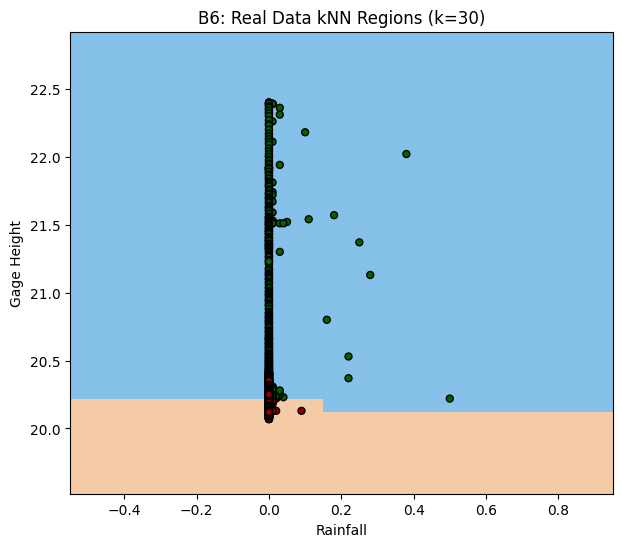

=== B7: Hyperparameter Tuning ===
Best k: 1
Cross-val Accuracy: 0.942


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    mean_squared_error, r2_score
)

# ---------------------------
# Load dataset
# ---------------------------
data = pd.read_csv("/content/merged_clean_dataset (1).csv")

# Keep only numeric columns we need
merged = data[['Gage_Height_ft', 'Precipitation_in', 'Reservoir_Storage_acre_ft', 'Stream_Flow_cfs']].dropna()

# ---------------------------
# B1: Classification using kNN
# ---------------------------
flowThreshold = merged['Stream_Flow_cfs'].median()
merged['flowClass'] = (merged['Stream_Flow_cfs'] > flowThreshold).astype(int)

X_cls = merged[['Precipitation_in', 'Gage_Height_ft']].values
y_cls = merged['flowClass'].values

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cls, y_cls, test_size=0.3, stratify=y_cls, random_state=123
)

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_c, y_train_c)
pred_train_c = knn.predict(X_train_c)
pred_test_c = knn.predict(X_test_c)

def check_classifier(y_true, y_pred):
    cmatrix = confusion_matrix(y_true, y_pred)
    return cmatrix, precision_score(y_true, y_pred), recall_score(y_true, y_pred), f1_score(y_true, y_pred)

cmTrain, pTrain, rTrain, f1Train = check_classifier(y_train_c, pred_train_c)
cmTest, pTest, rTest, f1Test = check_classifier(y_test_c, pred_test_c)

print("=== B1: kNN Streamflow Classification ===")
print("Train Confusion Matrix:\n", cmTrain)
print(f"Train -> Precision: {pTrain:.3f}, Recall: {rTrain:.3f}, F1: {f1Train:.3f}")
print("Test Confusion Matrix:\n", cmTest)
print(f"Test -> Precision: {pTest:.3f}, Recall: {rTest:.3f}, F1: {f1Test:.3f}")

# ---------------------------
# B2: Regression
# ---------------------------
X_reg = merged[['Precipitation_in', 'Gage_Height_ft', 'Reservoir_Storage_acre_ft']].values
y_reg = merged['Stream_Flow_cfs'].values

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=123
)

linReg = LinearRegression()
linReg.fit(X_train_r, y_train_r)
y_pred_r = linReg.predict(X_test_r)

def mape(true, pred):
    true, pred = np.array(true), np.array(pred)
    nz = true != 0
    return np.mean(np.abs((true[nz] - pred[nz]) / true[nz])) * 100

print("\n=== B2: Linear Regression on Flow ===")
print(f"MSE: {mean_squared_error(y_test_r, y_pred_r):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_r, y_pred_r)):.3f}")
print(f"MAPE: {mape(y_test_r, y_pred_r):.2f}%")
print(f"R²: {r2_score(y_test_r, y_pred_r):.3f}")

# ---------------------------
# B3: Synthetic Plot
# ---------------------------
np.random.seed(7)
points = np.random.uniform(0, 12, (24, 2))
labels = np.array([0]*12 + [1]*12)

plt.figure(figsize=(7, 6))
plt.scatter(points[:, 0], points[:, 1], c=labels, cmap=ListedColormap(['purple', 'orange']),
            s=90, edgecolor='black')
plt.title("B3: Synthetic Classification Data")
plt.xlabel("Attr X")
plt.ylabel("Attr Y")
plt.show()

# ---------------------------
# B4: Decision Surface k=3
# ---------------------------
knn_syn = KNeighborsClassifier(n_neighbors=3)
knn_syn.fit(points, labels)
xx, yy = np.meshgrid(np.arange(0, 12, 0.1), np.arange(0, 12, 0.1))
Z = knn_syn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(7, 6))
plt.pcolormesh(xx, yy, Z, cmap=ListedColormap(['#D7BDE2', '#F9E79F']), shading='auto')
plt.scatter(points[:, 0], points[:, 1], c=labels, cmap=ListedColormap(['purple', 'orange']),
            s=90, edgecolor='black')
plt.title("B4: Decision Boundary (k=3)")
plt.xlabel("Attr X")
plt.ylabel("Attr Y")
plt.show()

# ---------------------------
# B5: Compare multiple k
# ---------------------------
for kval in [1, 6, 12]:
    model = KNeighborsClassifier(n_neighbors=kval)
    model.fit(points, labels)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.figure(figsize=(7, 6))
    plt.pcolormesh(xx, yy, Z, cmap=ListedColormap(['#ABEBC6', '#F1948A']), shading='auto')
    plt.scatter(points[:, 0], points[:, 1], c=labels, cmap=ListedColormap(['purple', 'orange']),
                s=90, edgecolor='black')
    plt.title(f"B5: Decision Boundary k={kval}")
    plt.xlabel("Attr X")
    plt.ylabel("Attr Y")
    plt.show()

# ---------------------------
# B6: kNN Regions on Real Data
# ---------------------------
realX = merged[['Precipitation_in', 'Gage_Height_ft']].values
realY = merged['flowClass'].values

xMin, xMax = realX[:, 0].min()-0.5, realX[:, 0].max()+0.5
yMin, yMax = realX[:, 1].min()-0.5, realX[:, 1].max()+0.5
xxR, yyR = np.meshgrid(np.arange(xMin, xMax, 0.1), np.arange(yMin, yMax, 0.1))
gridR = np.c_[xxR.ravel(), yyR.ravel()]

for kval in [2, 5, 15, 30]:
    mdl = KNeighborsClassifier(n_neighbors=kval)
    mdl.fit(realX, realY)
    ZR = mdl.predict(gridR).reshape(xxR.shape)
    plt.figure(figsize=(7, 6))
    plt.pcolormesh(xxR, yyR, ZR, cmap=ListedColormap(['#F5CBA7', '#85C1E9']), shading='auto')
    plt.scatter(realX[:, 0], realX[:, 1], c=realY, cmap=ListedColormap(['darkred', 'darkgreen']),
                s=25, edgecolor='black')
    plt.title(f"B6: Real Data kNN Regions (k={kval})")
    plt.xlabel("Rainfall")
    plt.ylabel("Gage Height")
    plt.show()

# ---------------------------
# B7: Hyperparameter Search
# ---------------------------
paramGrid = {'n_neighbors': np.arange(1, 25, 2)}
search = GridSearchCV(KNeighborsClassifier(), param_grid=paramGrid, cv=5, scoring='accuracy')
search.fit(X_cls, y_cls)

print("=== B7: Hyperparameter Tuning ===")
print(f"Best k: {search.best_params_['n_neighbors']}")
print(f"Cross-val Accuracy: {search.best_score_:.3f}")
